In [8]:
import numpy as np

# === Load event data ===
data = np.loadtxt("../data/Auger/events_a8_lb.dat")
ra = data[:, 6]   # RA in degrees
dec = data[:, 7]  # Dec in degrees

# === Convert RA to radians ===
alpha = np.radians(ra)
N = len(alpha)

# === Rayleigh coefficients ===
a_alpha = (2 / N) * np.sum(np.cos(alpha))
b_alpha = (2 / N) * np.sum(np.sin(alpha))

# === Dipole amplitude and RA direction ===
r_alpha = np.sqrt(a_alpha**2 + b_alpha**2)
phi_alpha = np.arctan2(b_alpha, a_alpha)  # in radians
ra_dip = np.degrees(phi_alpha) % 360      # wrap to [0, 360)

print(f"Rayleigh dipole amplitude: {r_alpha:.4%}")
print(f"Dipole RA direction: {ra_dip:.2f}°")


Rayleigh dipole amplitude: 83.9938%
Dipole RA direction: 299.85°


In [2]:
from astropy.io import ascii

fluxmap = ascii.read("../data/Auger/flux_a8_lb.dat", format='csv')
fluxmap.keys()

['# dec   RA    Flux[km^-2_sr^-1_yr^-1]   Flux_uncertainty   GAL_LONGx1           GAL_LATx1']

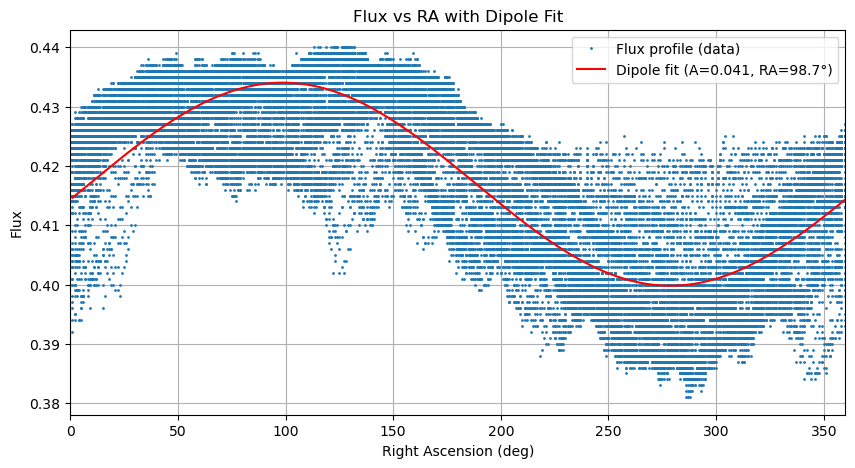

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

fluxmap = ascii.read("../data/Auger/flux_a8_lb.dat")

ra_flux = fluxmap['RA']  # RA in degrees
flux = fluxmap['Flux[km^-2_sr^-1_yr^-1]']

# Compute dipole amplitude and direction
def calculate_ra_dipole(ra_deg, flux):
    ra_rad = np.deg2rad(ra_deg)
    sum_w = np.sum(flux)
    x = np.sum(flux * np.cos(ra_rad))
    y = np.sum(flux * np.sin(ra_rad))
    r = 2.0 / sum_w * np.sqrt(x**2 + y**2)
    ra_dipole = np.rad2deg(np.arctan2(y, x)) % 360
    return r, ra_dipole

r_amp, ra_dir = calculate_ra_dipole(ra_flux, flux)

# Create model dipole curve for overlay
def dipole_model(ra_deg, mean_flux, amplitude, direction_deg):
    phase = np.deg2rad(ra_deg - direction_deg)
    return mean_flux * (1 + amplitude * np.cos(phase))

# Mean flux for normalization
mean_flux = np.mean(flux)
dipole_curve = dipole_model(ra_flux, mean_flux, r_amp, ra_dir)

# Plotting
# Sort RA and corresponding dipole model values
sorted_indices = np.argsort(ra_flux)
ra_sorted = ra_flux[sorted_indices]
flux_sorted = flux[sorted_indices]
dipole_sorted = dipole_curve[sorted_indices]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(ra_flux, flux, 'o', ms=1, label='Flux profile (data)')
plt.plot(ra_sorted, dipole_sorted, '-', color='red', label=f'Dipole fit (A={r_amp:.3f}, RA={ra_dir:.1f}°)')
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Flux')
plt.title('Flux vs RA with Dipole Fit')
plt.grid(True)
plt.legend()
plt.xlim(0, 360)
plt.show()


1233 3671


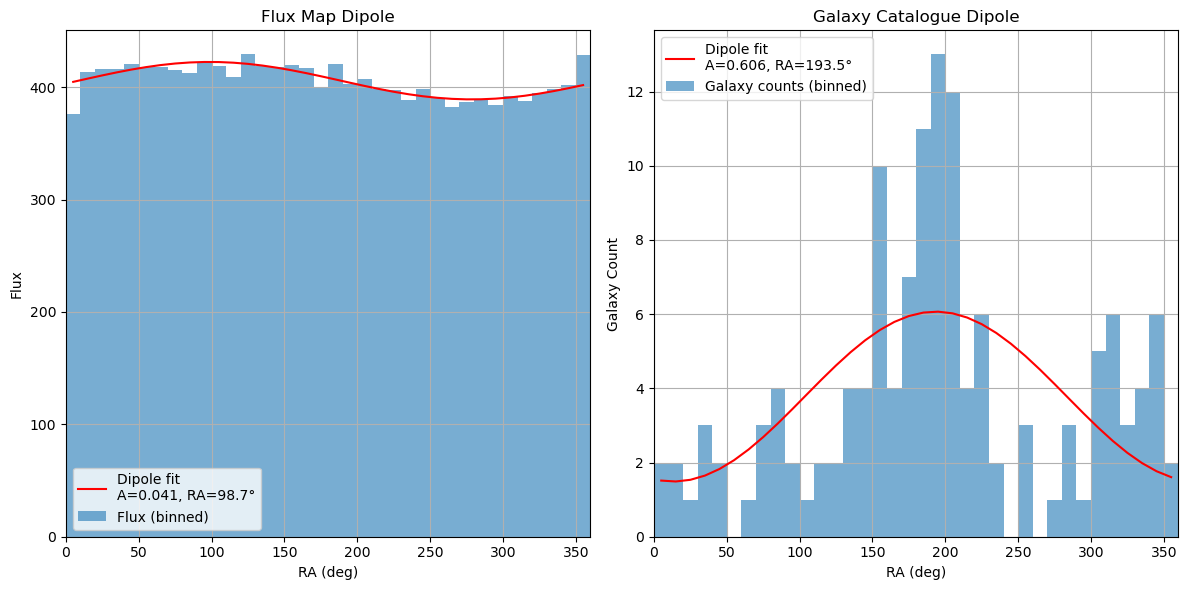

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

### === Load Data === ###
fluxmap = ascii.read("../data/Auger/flux_a8_lb.dat")
#gxs = ascii.read("../data/2MRSxWISE_sinBPTAGNs.txt")  
#gxs = ascii.read('../data/VLS_ang5_cz_700control_def.txt')
gxs = ascii.read('../data/VLS_WISEorBPT_AGNs.txt')
gxs = gxs[(gxs['cz'] > 1200) & (gxs['cz'] < 5000)]  # Filter galaxies by redshift
gxs = gxs[gxs['K_abs']<-24.]  # Filter galaxies by absolute magnitude
print(gxs['cz'].min(), gxs['cz'].max())  # Check the redshift range

# Extract RA and flux
ra_flux = fluxmap['RA']
flux = fluxmap['Flux[km^-2_sr^-1_yr^-1]']

ra_gxs = gxs['_RAJ2000']  # Galaxy RA in degrees


### === Dipole Calculation Function === ###
def calculate_ra_dipole(ra_deg, weights=None):
    ra_rad = np.deg2rad(ra_deg)
    if weights is None:
        weights = np.ones_like(ra_deg)
    total_weight = np.sum(weights)
    x = np.sum(weights * np.cos(ra_rad))
    y = np.sum(weights * np.sin(ra_rad))
    r = 2.0 / total_weight * np.sqrt(x**2 + y**2)
    ra_dipole = np.rad2deg(np.arctan2(y, x)) % 360
    return r, ra_dipole


### === Dipole Model === ###
def dipole_model(ra_deg, mean, amplitude, direction):
    phase = np.deg2rad(ra_deg - direction)
    return mean * (1 + amplitude * np.cos(phase))


### === Binning Function === ###
def bin_data(ra_data, weights=None, bin_width=10):
    bins = np.arange(0, 360 + bin_width, bin_width)
    ra_centers = 0.5 * (bins[:-1] + bins[1:])
    if weights is None:
        counts, _ = np.histogram(ra_data, bins=bins)
    else:
        counts, _ = np.histogram(ra_data, bins=bins, weights=weights)
    return ra_centers, counts


### === Flux Map Dipole === ###
r_flux, dir_flux = calculate_ra_dipole(ra_flux, weights=flux)
ra_centers_flux, flux_binned = bin_data(ra_flux, weights=flux)
flux_fit = dipole_model(ra_centers_flux, np.mean(flux_binned), r_flux, dir_flux)

### === Galaxy Catalogue Dipole === ###
r_gxs, dir_gxs = calculate_ra_dipole(ra_gxs)
ra_centers_gxs, gxs_binned = bin_data(ra_gxs)
gxs_fit = dipole_model(ra_centers_gxs, np.mean(gxs_binned), r_gxs, dir_gxs)

### === Plotting === ###
plt.figure(figsize=(12, 6))

# Flux map
plt.subplot(1, 2, 1)
plt.bar(ra_centers_flux, flux_binned, width=10, alpha=0.6, label='Flux (binned)')
plt.plot(ra_centers_flux, flux_fit, 'r-', label=f'Dipole fit\nA={r_flux:.3f}, RA={dir_flux:.1f}°')
plt.xlabel('RA (deg)')
plt.ylabel('Flux')
plt.title('Flux Map Dipole')
plt.legend()
plt.grid(True)
plt.xlim(0, 360)

# Galaxy catalogue
plt.subplot(1, 2, 2)
plt.bar(ra_centers_gxs, gxs_binned, width=10, alpha=0.6, label='Galaxy counts (binned)')
plt.plot(ra_centers_gxs, gxs_fit, 'r-', label=f'Dipole fit\nA={r_gxs:.3f}, RA={dir_gxs:.1f}°')
plt.xlabel('RA (deg)')
plt.ylabel('Galaxy Count')
plt.title('Galaxy Catalogue Dipole')
plt.legend()
plt.grid(True)
plt.xlim(0, 360)

plt.tight_layout()
plt.show()


=== Corrected 3D Dipoles ===
Galaxies: Amplitude = 0.1955, RA = 48.94°, Dec = 78.98°
Flux:     Amplitude = 0.0165, RA = 113.54°, Dec = -26.71°

=== Uncorrected Dipoles ===
Galaxies: Amplitude = 0.0601, RA = 39.60°, Dec = 49.97°
Flux:     Amplitude = 0.1577, RA = 98.50°, Dec = -83.47°


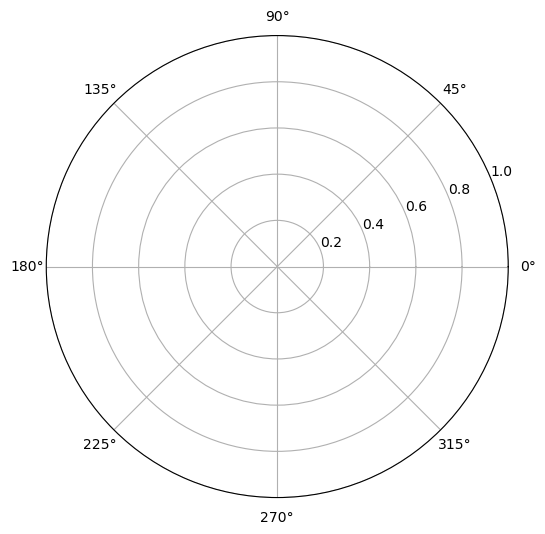

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

# --- Load Data ---
fluxmap = ascii.read("../data/Auger/flux_a8_lb.dat")
gxs = ascii.read("../data/2MRSxWISE_sinBPTAGNs.txt")  # Replace with your real galaxy file

# Extract coordinates
ra_flux = np.array(fluxmap['RA'])
dec_flux = np.array(fluxmap['dec'])
flux = np.array(fluxmap['Flux[km^-2_sr^-1_yr^-1]'])

ra_gxs = np.array(gxs['_RAJ2000'])
dec_gxs = np.array(gxs['_DEJ2000'])

# --- Dipole Calculation ---
def compute_3d_dipole(ra_deg, dec_deg, weights=None):
    ra = np.deg2rad(ra_deg)
    dec = np.deg2rad(dec_deg)
    if weights is None:
        weights = np.ones_like(ra)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    total_weight = np.sum(weights)
    D_x = np.sum(weights * x) / total_weight
    D_y = np.sum(weights * y) / total_weight
    D_z = np.sum(weights * z) / total_weight
    vec = np.array([D_x, D_y, D_z])
    norm = np.linalg.norm(vec)
    ra_dip = np.rad2deg(np.arctan2(D_y, D_x)) % 360
    dec_dip = np.rad2deg(np.arcsin(D_z / norm))
    return vec, norm, ra_dip, dec_dip

# --- Random Catalogue Generator ---
def generate_random_catalogue(N, dec_min_deg=-90, dec_max_deg=45):
    ra_rand = np.random.uniform(0, 360, N)
    sin_dec_min = np.sin(np.deg2rad(dec_min_deg))
    sin_dec_max = np.sin(np.deg2rad(dec_max_deg))
    sin_dec_rand = np.random.uniform(sin_dec_min, sin_dec_max, N)
    dec_rand = np.rad2deg(np.arcsin(sin_dec_rand))
    return ra_rand, dec_rand

# --- Galaxy Dipole ---
vec_gxs, norm_gxs, ra_gxs_dip, dec_gxs_dip = compute_3d_dipole(ra_gxs, dec_gxs)

# --- Galaxy Random Dipole ---
ra_rand_gxs, dec_rand_gxs = generate_random_catalogue(len(ra_gxs))
vec_rand_gxs, norm_rand_gxs, _, _ = compute_3d_dipole(ra_rand_gxs, dec_rand_gxs)

# --- Galaxy Corrected Dipole ---
vec_corr_gxs = vec_gxs - vec_rand_gxs
norm_corr_gxs = np.linalg.norm(vec_corr_gxs)
ra_corr_gxs = np.rad2deg(np.arctan2(vec_corr_gxs[1], vec_corr_gxs[0])) % 360
dec_corr_gxs = np.rad2deg(np.arcsin(vec_corr_gxs[2] / norm_corr_gxs))

# --- Flux Dipole ---
vec_flux, norm_flux, ra_flux_dip, dec_flux_dip = compute_3d_dipole(ra_flux, dec_flux, weights=flux)

# --- Flux Random Dipole ---
ra_rand_flux, dec_rand_flux = generate_random_catalogue(len(ra_flux))
vec_rand_flux, norm_rand_flux, _, _ = compute_3d_dipole(ra_rand_flux, dec_rand_flux)

# --- Flux Corrected Dipole ---
vec_corr_flux = vec_flux - vec_rand_flux
norm_corr_flux = np.linalg.norm(vec_corr_flux)
ra_corr_flux = np.rad2deg(np.arctan2(vec_corr_flux[1], vec_corr_flux[0])) % 360
dec_corr_flux = np.rad2deg(np.arcsin(vec_corr_flux[2] / norm_corr_flux))

# # --- Plot ---
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='polar')

# # Convert to theta (RA) and r (90 - Dec)
# def sph_to_polar(ra_deg, dec_deg):
#     theta = np.deg2rad(ra_deg)  # angle around circle
#     r = 90 - dec_deg  # radial distance (zenithal projection)
#     return theta, r

# # Plot dipoles
# labels = ['Galaxies', 'Flux']
# colors = ['blue', 'red']
# dipoles = [(ra_corr_gxs, dec_corr_gxs), (ra_corr_flux, dec_corr_flux)]

# for (ra_dip, dec_dip), label, color in zip(dipoles, labels, colors):
#     theta, r = sph_to_polar(ra_dip, dec_dip)
#     ax.plot([theta], [r], 'o', label=f'{label}\nRA={ra_dip:.1f}°, Dec={dec_dip:.1f}°', color=color)

# ax.set_title('Corrected 3D Dipole Directions (Galaxies vs Flux)', va='bottom')
# ax.set_rmax(90)
# ax.set_rticks([30, 60, 90])  # declination circles
# ax.set_rlabel_position(225)  # move labels away from overlap
# ax.grid(True)
# ax.legend(loc='upper right')

# plt.show()

print("=== Corrected 3D Dipoles ===")
print(f"Galaxies: Amplitude = {norm_corr_gxs:.4f}, RA = {ra_corr_gxs:.2f}°, Dec = {dec_corr_gxs:.2f}°")
print(f"Flux:     Amplitude = {norm_corr_flux:.4f}, RA = {ra_corr_flux:.2f}°, Dec = {dec_corr_flux:.2f}°")

print("\n=== Uncorrected Dipoles ===")
print(f"Galaxies: Amplitude = {norm_gxs:.4f}, RA = {ra_gxs_dip:.2f}°, Dec = {dec_gxs_dip:.2f}°")
print(f"Flux:     Amplitude = {norm_flux:.4f}, RA = {ra_flux_dip:.2f}°, Dec = {dec_flux_dip:.2f}°")

